# _Who has a voice in the media?_

## 1. Pre-processing the dataset
In this study of "_Who has a voice in the media_", the **speaker identity and what it said is vital**. Thus, we remove the following rows from the original dataset:
- rows where either the author or the quotation is NaN; 
- rows where the author has probability lower than 50%. 

Later, we also do a sanity controll and **remove possible duplicate of rows** with the same quote-ID as we obiously don't want to use exactly the same quote more than once in our analyzes. 

Finally, to reduce the dataset further we **remove columns** that we will not use for our analysis: _quoteID_, _speaker_, _probas_, _urls_, _phase_ and _numOccurrences_.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import time
from datetime import datetime
from timeit import default_timer as timer
from collections import Counter
from qwikidata.linked_data_interface import get_entity_dict_from_api
from qwikidata.entity import WikidataItem
from pathlib import Path

In [3]:
def clean_data(chunk, thresh=0.5):
    """
    Drop duplicate quoteIDs, drop quotes where speaker/quotation is None, remove uninteresting columns.
    """
    # Drop duplicate quoteIDs
    nr_rows = chunk.shape[0]
    chunk = chunk.drop_duplicates(subset=['quoteID'])
    print('- Dropped {} duplicate rows with same quoteID;'.format(nr_rows - chunk.shape[0]))
    
    # Drop quotes where either speaker or quotation is None
    nr_rows = chunk.shape[0]
    chunk.replace(to_replace=['None'], value=np.nan, inplace=True)
    chunk = chunk.dropna(axis=0, subset=['speaker', 'quotation'])
    print('- Dropped {} rows with NaN speaker or quotation;'.format(nr_rows - chunk.shape[0]))
    
    # Drop rows where speakers has probability less than 50%
    nr_rows = chunk.shape[0]
    prob_filter = pd.Series([(float(chunk.iloc[i].probas[0][1]) > thresh) for i in range(nr_rows)])
    prob_filter = pd.Series(prob_filter)
    chunk = chunk[prob_filter.values]
    print('- Dropped {} rows with speaker prob smaller than 50%;'.format(nr_rows - chunk.shape[0]))

    # Remove columns we don't care about
    chunk = chunk.drop(columns=['quoteID', 'speaker', 'probas', 'urls', 'phase', 'numOccurrences'])

    return chunk


def main_clean(read_from_file, write_to_file):
    """
    Main function for cleaning data. Reads .json.bz2 file and writes to .csv.bz2.
    """
    start_of_all = timer()
    with pd.read_json(read_from_file, lines=True, compression='bz2', chunksize=1_000_000) as df_reader:
        print('Started to process chunks...')
        i = 0
        for chunk in df_reader:
            print('\nProcessing new chunk...')
            start = timer()
            processed_chunk = clean_data(chunk)
            processed_chunk.to_csv(write_to_file, compression='bz2', mode='a', index=False)
            end = timer()
            print('Done processing and saving chunk after {:.3f} seconds.'.format(end - start))
    end_of_all = timer()
    print('\nDONE processing all chunks and saving as csv after {:.3f} minutes.'.format((end_of_all - start_of_all) / 60))
    print('THE END!')
    
# ---- UNCOMMENT & RUN the row below if pre-processing needs to be done! -----
# main_clean(read_from_file='data/quotes-2016.json.bz2', write_to_file='data/clean-quotes-2016.bz2')

#### Short discussion around pre-processing
Around one third of the original dataset has either a NaN quotation field, a NaN speaker, or a speaker with lower than 50% probability of having said that quote. Another one third of the original data is removed by the removal of the unwanted columns. Thus we are left with one third of the original dataset and still with full possibility of doing the wanted analysis. Elsemore, it seems like there are no duplicates of quote-IDs in the dataset. Finally, we realized that we might need to rerun the pre-processing so as to not filter out the URL column.

## 2. Initial analysis
Here, we do initial studies on the content of the dataset. For instance we plot the following information about the speakers:
- occupation;
- gender;
- age;
- ethnicity;
- top 20 speakers.
**OBS! For practical reasons, in the initial analysis in Milestone 2, we randomly picked 100,000 quotations of each year instead of dealing with the whole data. The code and the analysis will basically remain the same but only need to be run for a longer time.**

In [3]:
datafolder = Path("data")

DATA = {
    '2015': 'data/clean-quotes-2015.bz2',
    '2016': 'data/clean-quotes-2016.bz2',
    '2017': 'data/clean-quotes-2017.bz2',
    '2018': 'data/clean-quotes-2018.bz2',
    '2019': 'data/clean-quotes-2019.bz2',
    '2020': 'data/clean-quotes-2020.bz2',
}

ALL_YEARS = ['2015', '2016', '2017', '2018', '2019', '2020']

def load_data(year, sample=True, sample_size=100_000):
    if DATA[year].exists():
        df = pd.read_csv(DATA[year], compression='bz2')
        if sample:
            df = df.sample(n=sample_size, random_state=1)
    else:
        return None 
    
wikidata_speakers = pd.read_parquet('data/speaker_attributes.parquet')
wikidata_speakers.set_index('id', inplace=True)

In [7]:
df = load_data('2020')
if df is None:
    raise Exception('Failed to load dataset')

Exception: Failed to load dataset

### 2.1 Occupation distribution in 2020
In this part of our initial analysis, we discover the distribution of occupations among the quoted speakers for the year of 2020.

In [94]:
# Get the qids from the quotations df:
qids = df.qids.tolist()
# Out of unique_qids, keep the qids of unambiguous speakers whose qid exists in the parquet file:
wanted_qids = [eval(qid)[0] for qid in qids if len(eval(qid)) == 1 and eval(qid)[0] in wikidata_speakers.index]

# Get the rows of the speakers having the wanted qids
speakers = wikidata_speakers.loc[wanted_qids]
# Get the speakers occupations and count them
occupation_ids = [occ_id[0] for occ_id in speakers.occupation.values if not occ_id is None]
occupation_count = Counter(occupation_ids)
occupation_count_sorted = dict(sorted(occupation_count.items(), key=lambda x: x[1], reverse=True)) 
top_50_occupations = dict(itertools.islice(occupation_count_sorted.items(), 50)) 

# Query wikidata for occupation labels
top_50_occupations_labels = [get_entity_dict_from_api(item)['labels']['en']['value'] for item in top_50_occupations.keys()]

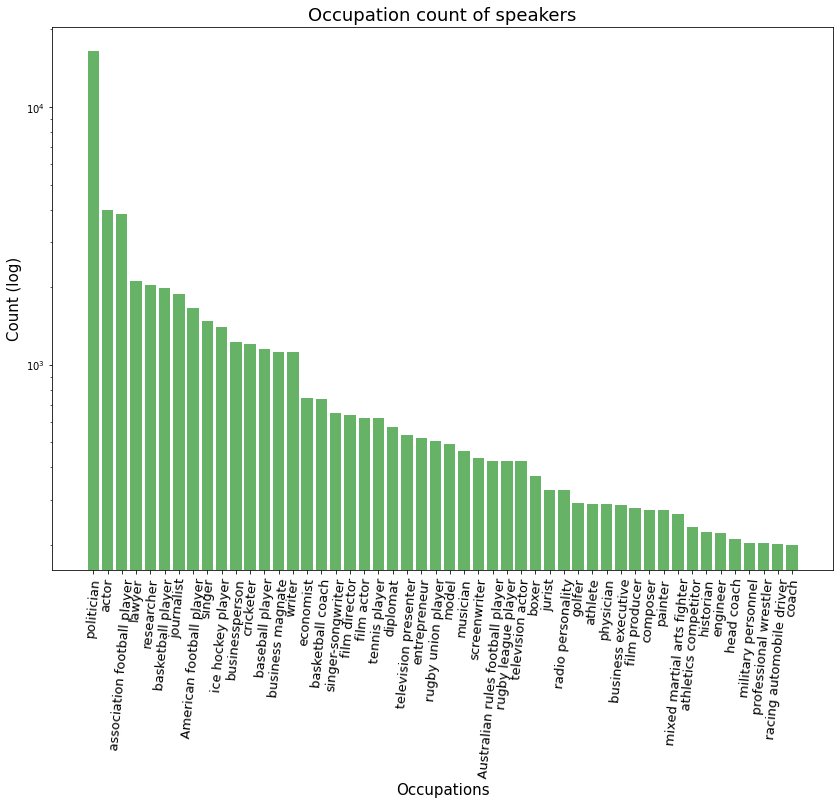

In [77]:
# Plot 
_ = plt.figure(figsize=(14, 10))
_ = plt.title('Occupation count of speakers', fontsize=18)
_ = plt.xlabel('Occupations', fontsize=15)
_ = plt.ylabel('Count (log)', fontsize=15)
_ = plt.bar(top_50_occupations.keys(), top_50_occupations.values(), color='g', log=True, alpha=0.6)
_ = plt.xticks(range(len(top_50_occupations)), top_50_occupations_labels, rotation=85, fontsize=13)

As expected from the picture in the project's README, the group that is mostly represented is **politicians**. See for instance the dominating names: Donald Trump, Joe Biden, Bernie Sanders and Andrew Cuomo.

Followed by politicians, a significant number of **athletes** of football, American football and basketball appear. As the newspapers come from the English-speaking world, mainly US and UK, it is expected that athletes from the most famous sports in these countries are present. Names such as Jose Mourinho, Lebron James and Kobe Bryant are clearly visible.

### 2.2 Gender distribution 2016-2020

In [6]:
def count_genders(df):
        """
        Counts the distribution of genders in a dataframe, ignores speakers that are not found in wikidata.
        If a person has multiple genders (yes this can happen), all are considered.
        """
        ids = [eval(id)[0] for id in df.qids.tolist() if id and eval(id)[0] in wikidata_speakers.index]
        persons = wikidata_speakers.loc[ids]
        all_genders = [item for sublist in persons.gender.tolist() if sublist is not None for item in sublist ]        
        genders = Counter(all_genders)
        return genders

#### Calculate the gender distribution

In [23]:
qid_man = "Q6581097"
qid_woman = "Q6581072"

gender_distribution = {} # {year: {qid: count}

# Loops through all years and counts the distribution of genders
for year in ALL_YEARS:
    start = time.time()
    df = load_dev_data(year) 
    if df is None:
        print(f'warning: could not find year:{year}')
        continue    
    gender_distribution[year] = count_genders(df) 
    end = time.time()
    print(f'processed year {year} in {end-start} seconds')

# Groups all non-binary genders into the same category
condensed_gender_distribution = {year: 
                                 {'women': data[qid_woman], 
                                  'men': data[qid_man], 
                                  'other': sum(v for gender,v in data.items() if gender not in [qid_man, qid_woman])} 
                                     for year, data in gender_distribution.items()}

processed year 2016 in 112.29911208152771 seconds
processed year 2018 in 207.43278312683105 seconds
processed year 2019 in 169.93023896217346 seconds
processed year 2020 in 45.94757318496704 seconds


#### Plot the gender distribution

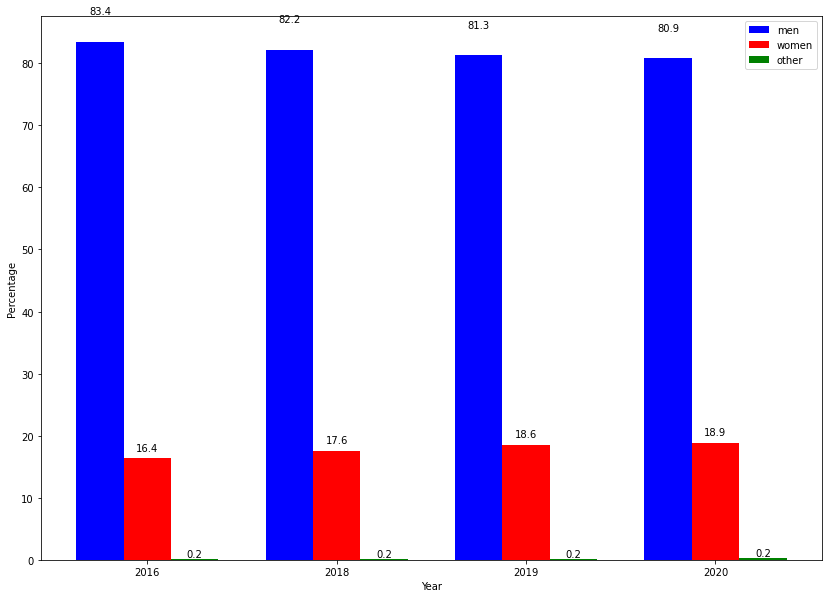

In [70]:
N = len(condensed_gender_distribution)
ind = np.arange(N)
width = 0.25

fig = plt.figure()
fig.set_size_inches(14, 10)
ax = fig.add_subplot(111)
men = []
women = []
other = []
for year, data in condensed_gender_distribution.items():
    men.append(data['men'] * 100 / (sum(data.values())) )
    women.append(data['women'] * 100 / (sum(data.values())))
    other.append(data['other'] * 100 / (sum(data.values())))
                 
rects1 = ax.bar(ind, men, width, color='b')
rects2 = ax.bar(ind+width, women, width, color='r')
rects3 = ax.bar(ind+width*2, other, width, color='g')

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
    
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                str(round(height, 1)), ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

ax.set_ylabel('Percentage')
ax.set_xlabel('Year')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('2016', '2018', '2019', '2020') )
ax.legend( (rects1[0], rects2[0], rects3[0]), ('men', 'women', 'other') )
plt.show()

Two main conclusion can be drawn from the graph:
   - Men are heavily overrepresentated compared to women;
   - The gap is slowly decreasing.

### 2.3 Age distribution in 2020
In this part of our analysis, we discover the distribution of the age among the quoted speakers for the year of 2020.

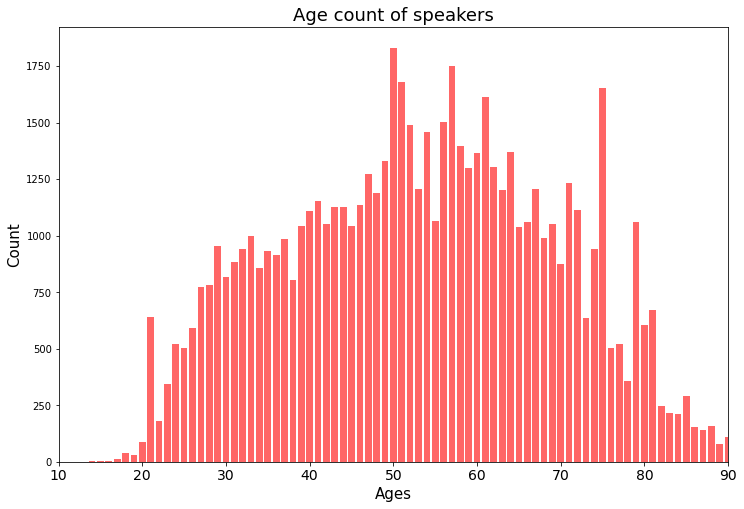

In [78]:
# OBS: We reuse the variable 'speakers' found in the cell about Occupation.

# Get the ages of the 100_000 authors
current_year = datetime.now().year
ages = [current_year - int(date[0][1:5]) for date in speakers.date_of_birth.values if not date is None]
ages_count = Counter(ages)

# Plot 
_ = plt.figure(figsize=(12, 8))
_ = plt.title('Age count of speakers', fontsize=18)
_ = plt.xlabel('Ages', fontsize=15)
_ = plt.ylabel('Count', fontsize=15)
_ = plt.xlim(10, 90)
_ = plt.bar(ages_count.keys(), ages_count.values(), color='r', log=False, alpha=0.6, width=0.8)
_ = plt.xticks(fontsize=14)

We see that the greater majority of the speakers are aged between 45 and 65 years. This is expected as politicians, which make the greater majority of this dataset as seen from the histogram aforementioned, use to be older adults. One interesting outlier is the peak at the age of 21 years; it might be interesting to discover who these quoted 21-year olds are in a further analysis of the dataset.

### 2.4 Ethnicity distribution in 2020
In this part of our analysis, we discover the distribution of the ethnicity among the quoted speakers for the year of 2020.

In [79]:
# OBS: We reuse the variable 'speakers' found in the cell about Occupation.
ethnicity_percentage = speakers.ethnic_group.isna().sum() / speakers.shape[0]
print('The percentage of authors with a set ethnicity value in the provided .parquet file is {:.2f}%.'.format((1-ethnicity_percentage)*100))

The percentage of authors with a set ethnicity value in the provided .parquet file is 11.33%.


In [80]:
ethnic_ids = [ethnic_id[0] for ethnic_id in speakers.ethnic_group.values if ethnic_id is not None]
ethnic_count = Counter(ethnic_ids)

# Manual grouping of the top 20 ethnicity groups into: black, white and asian (ethnicities that American companies normally use)
ethnic_count_manual = {'black':  ethnic_count['Q49085'] + ethnic_count['Q190168'] + ethnic_count['Q244157'] + 
                                 ethnic_count['Q33938'] + ethnic_count['Q129962'],
                       
                       'white':  ethnic_count['Q7325'] + ethnic_count['Q678551'] + ethnic_count['Q2325516'] + 
                                 ethnic_count['Q170826'] + ethnic_count['Q974693'] + ethnic_count['Q1075293'] + 
                                 ethnic_count['Q42406'] + ethnic_count['Q842438'] + ethnic_count['Q49078'] + 
                                 ethnic_count['Q79797'] + ethnic_count['Q7994501'] + ethnic_count['Ashkenazi Jews'],
                       
                       'asians': ethnic_count['Q932244'] + ethnic_count['Q854323'] + ethnic_count['Q862086'],
                       
                       'indigeneous': 0
                      }

ethnic_count_sorted = dict(sorted(ethnic_count_manual.items(), key=lambda x: x[1], reverse=True)) 
# ethnic_count_sorted = dict(sorted(ethnic_count.items(), key=lambda x: x[1], reverse=True)) 
top_20_ethnicities = dict(itertools.islice(ethnic_count_sorted.items(), 20)) 

# Query wikidata for occupation labels
# top_20_ethnicities_labels = [get_entity_dict_from_api(item)['labels']['en']['value'] for item in top_20_ethnicities.keys()]

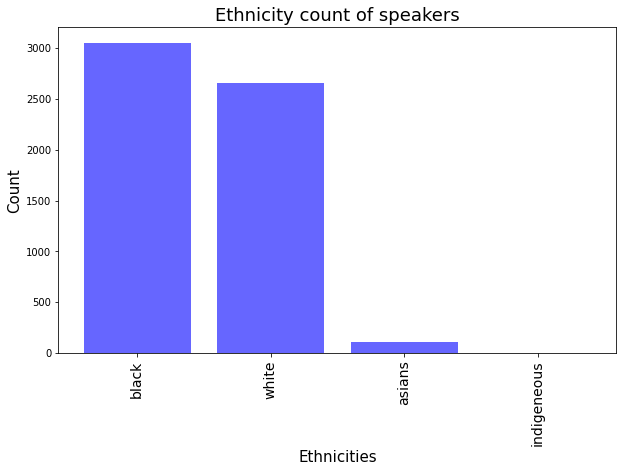

In [81]:
# Plot 
_ = plt.figure(figsize=(10, 6))
_ = plt.title('Ethnicity count of speakers', fontsize=18)
_ = plt.xlabel('Ethnicities', fontsize=15)
_ = plt.ylabel('Count', fontsize=15)
_ = plt.bar(top_20_ethnicities.keys(), top_20_ethnicities.values(), color='b', log=False, alpha=0.6)
_ = plt.xticks(range(len(top_20_ethnicities)), top_20_ethnicities, rotation=90, fontsize=14)

As can be seen from the calculations made on the random set of authors, the percentage of them who have a set _ethnicity value_ in the provided WikiData dump is only 5%. Furthermore, a manual grouping of the groups into the smaller groups white, black, asian and indigenous was made. The **unexpected result** that black people are quoted around 5 times more than white people was achieved as seen from the histogram above. 

A **possible reason** for this phenomenum is that **black people's ethnicity are more often written than white in WikiData**. This is verified by for instance checking that Donald Trump and Joe Biden (two of the most quoted authors) do not have an ethnicity set on the gotten WikiData parquet file.

### 2.5 Top 20 speakers in 2016 & 2020

To se which people get quoted the most we plot the distribution of the top 20 most quoted speakers

In [195]:
def count_top_speakers(df, n=20):
    qids = df.qids.tolist()
    wanted_qids = [eval(qid)[0] for qid in qids if len(eval(qid)) == 1 and eval(qid)[0] in wikidata_speakers.index]
    speakers = wikidata_speakers.loc[wanted_qids]
    top_n_speakers = speakers.groupby(['id', 'label']).size().reset_index(name='counts').nlargest(n, 'counts')
    top_n_speakers_dict = dict(zip(top_n_speakers.label, top_n_speakers.counts))
    return top_n_speakers_dict
    
top_20_speakers = {}

for year in ALL_YEARS:
    start = time.time()
    df = load_dev_data(year) 
    if df is None:
        print(f"warning: could not find year:{year}")
        continue    
    top_20_speakers[year] = count_top_speakers(df, n=20) 
    end = time.time()
    print(f"processed year {year} in {end-start} seconds")

processed year 2016 in 107.67273807525635 seconds
processed year 2018 in 215.4778299331665 seconds
processed year 2019 in 173.83351135253906 seconds
processed year 2020 in 42.398391008377075 seconds


#### Plots for year 2016 and 2020

These two years are interesting to compare since they both were election years, and indeed we can see that the top speakers are people that were candidates in the respective election with a very strange exception for Donald Trump in 2016 (this will require further analysis). We can also see that Anthony Fauci, a member of Trumps Coronavirus task force, was one of the most quoted people during the year 2020.

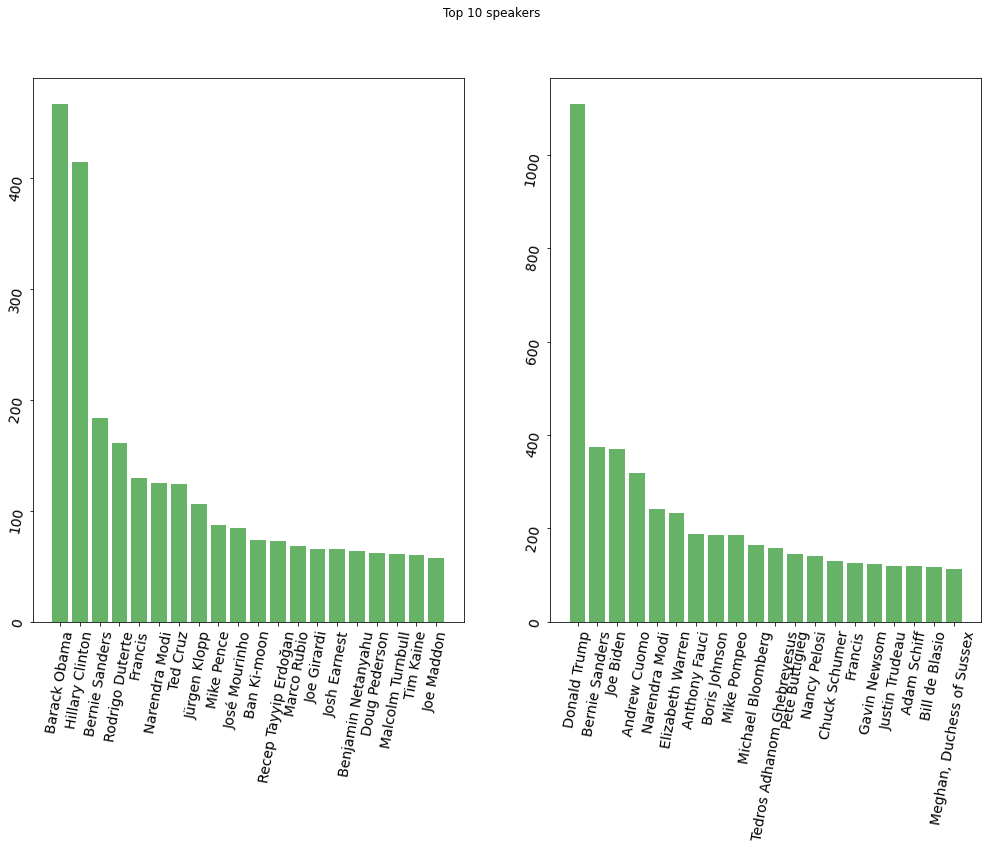

In [199]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Top 10 speakers')
fig.set_size_inches(17, 10)
ax1.bar(top_20_speakers['2016'].keys(), top_20_speakers['2016'].values(), color='g', log=False, alpha=0.6)
ax2.bar(top_20_speakers['2020'].keys(), top_20_speakers['2020'].values(), color='g', log=False, alpha=0.6)
ax1.tick_params(labelrotation=80,  labelsize=14)
ax2.tick_params(labelrotation=80,  labelsize=14)

## 3. Conclusion

Here, we present a summary of our findings and plan for the continuation of the data analysis.

**Pre-processing**:
- with the cleaning of the data, we are left with around one third of the original data which speeds the analysis;
- we might need to rerun the pre-processing as we realized we are also interested in knowing where the quotation comes from, so the URL column will not be filtered out.

**Findings**:
- occupation: for 2020, politicians dominate, followed by athletes of famous sports in the US and UK;
- gender: the media is dominated by men but women are slowly catching up;
- age: in 2020, the mean age of the quoted speakers is ~60;
- ethnicity: the ethnicity plot was unexpected and must be considered with care, it resulted from a lack of ethinic data for white speakers in WikiData;
- top 20 speakers: in both 2016 and 2020, the top quoted speakers were politicians, especially ones that were at the time running for the US president election.

**Future analysis**:
- explore how occupation and age distribution changed over the years;
- explore the correlation between the features;
- explore oddities in data, e.g. who are the cited 21-year olds in 2020;
- using the URL and information about where the URL is geographically located, study how the aspect of the features above change in function of the geographic location;
- when satisfied with the findings of the 100,000 samples, run it for the whole size of all of the years data.

